### Imports

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinReg


### Initial Examination of the provided data

In [2]:
# Reading in the provided CSV file

df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.shape

(14723, 272)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


### Creating a dataframe with a datetime index

In [5]:
def zipcodecolumns_datetimeindex(df):
    '''
    Very specific function that takes our provided dataframe, df, and changes
    it so that the zipcode, RegionName, is the index and the columns are all
    the timeseries data
    Assumes each zipcode is unique!
    
    Expected inputs:
    df - The provided pandas dataframe with all original columns, where the 
         dates are unfortunately the columns and not easily indexable
         
    Output:
    df_datetime - pandas dataframe where the datetime is now the index, and
                  each column is now the zipcode, RegionName
                  The other metadata columns are dropped
    '''
    # Changes the index to be each zipcode
    df_zipcode = df.set_index(df["RegionName"])
    
    # Drops the metadata columns from the provided df
    df_zipcode = df_zipcode.drop(columns=["RegionID", "RegionName", 
                                          "City", "State", "Metro", 
                                          "CountyName", "SizeRank"])
    # Transposes the df, so now the remaining columns (dates) are the index
    df_datetime = df_zipcode.transpose()
    # Changes those dates to be actual datetime objects instead of strings
    df_datetime.index = pd.to_datetime(df_datetime.index)
    
    return df_datetime

In [6]:
df_t = zipcodecolumns_datetimeindex(df)
df_t.shape

(265, 14723)

### Overall View of the National Average

In [29]:
df_t.head()

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


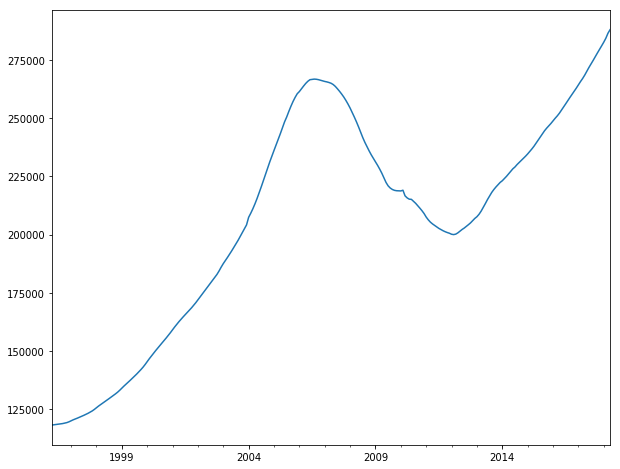

In [36]:
# Creating a new column with the monthly average across all of our columns
df_t["National Average"] = df_t.iloc[:, 1:-1].mean(axis=1)

# Creating a simple plot of that average
plt.figure(figsize=(10,8))
df_t["National Average"].plot()
plt.show()

### Playing around with data at the state level, looking only at Texas

In [10]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [11]:
df_tx = df.loc[df["State"] == "TX"]

In [12]:
df_tx.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [13]:
# Using our pre-defined function to create a df with a datetime index
tx_dtindex = zipcodecolumns_datetimeindex(df_tx)

In [14]:
tx_dtindex.head()

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
1996-04-01,235700.0,210400.0,77300.0,95000.0,95400.0,138900.0,141400.0,138500.0,119700.0,69900.0,...,NaN,141700.0,60700.0,90700.0,86000.0,NaN,NaN,NaN,134500.0,90700.0
1996-05-01,236900.0,212200.0,77300.0,95200.0,95600.0,138600.0,141000.0,138700.0,119700.0,69700.0,...,NaN,141800.0,61100.0,90900.0,86200.0,NaN,NaN,NaN,134500.0,91000.0
1996-06-01,236700.0,212200.0,77300.0,95400.0,95800.0,138400.0,140600.0,139200.0,119800.0,69600.0,...,NaN,141900.0,61400.0,91000.0,86500.0,NaN,NaN,NaN,134400.0,91200.0
1996-07-01,235400.0,210700.0,77300.0,95700.0,96100.0,138500.0,140500.0,139900.0,119900.0,69300.0,...,NaN,142000.0,61800.0,91100.0,86700.0,NaN,NaN,NaN,134400.0,91500.0
1996-08-01,233300.0,208300.0,77400.0,95900.0,96400.0,138700.0,140400.0,140700.0,120000.0,69100.0,...,NaN,142200.0,62100.0,91300.0,86800.0,NaN,NaN,NaN,134300.0,91800.0


#### Looking at the State-Level Trend

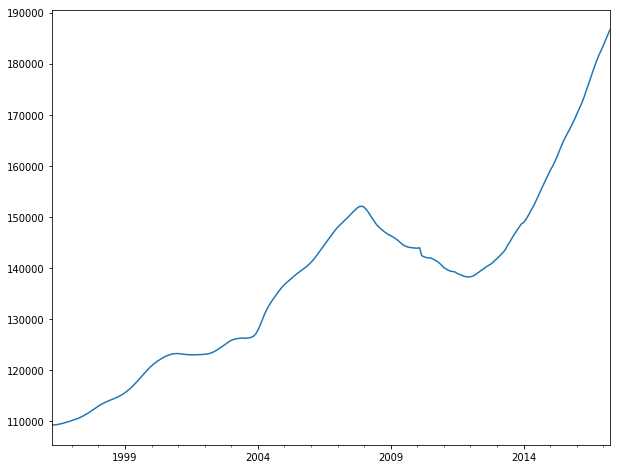

In [35]:
# Creating a new column with the monthly average across all TX zipcodes
tx_dtindex["Texas Average"] = tx_dtindex.iloc[:, 1:-1].mean(axis=1)

# Simple plot of the TX average
plt.figure(figsize=(10,8))
tx_dtindex["Texas Average"].plot()
plt.show()

In [19]:
# Creating a df of the last year of the Texas df, as our test data
tx_future = tx_dtindex.loc["2017-05":"2018-04"]
tx_future

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
2017-05-01,306200.0,320000.0,118600.0,157700.0,166700.0,232700.0,247200.0,247100.0,181200.0,97200.0,...,87600.0,258200.0,154700.0,194600.0,150200.0,122100.0,52500.0,99700.0,250300.0,245800.0
2017-06-01,307000.0,320900.0,118900.0,157700.0,166700.0,233900.0,248400.0,248100.0,182400.0,98700.0,...,87400.0,258500.0,156100.0,195900.0,150400.0,122800.0,53700.0,100000.0,252000.0,247700.0
2017-07-01,308000.0,321000.0,119100.0,157900.0,166800.0,235000.0,249800.0,249100.0,183200.0,99800.0,...,88100.0,256100.0,155700.0,197600.0,150500.0,122500.0,55400.0,100500.0,252100.0,250400.0
2017-08-01,310000.0,320600.0,119400.0,158700.0,167400.0,235900.0,251300.0,249900.0,183700.0,100300.0,...,88300.0,254100.0,151300.0,200200.0,150400.0,121800.0,56300.0,100500.0,251600.0,253300.0
2017-09-01,312500.0,320200.0,120000.0,160200.0,168400.0,236600.0,252300.0,250500.0,184500.0,100300.0,...,87600.0,253900.0,147400.0,203700.0,150100.0,121600.0,55700.0,101000.0,251600.0,256900.0
2017-10-01,314100.0,320400.0,120300.0,161900.0,169600.0,237400.0,252400.0,250700.0,185300.0,100100.0,...,87600.0,255500.0,146500.0,204900.0,149900.0,122200.0,56300.0,100700.0,251500.0,256100.0
2017-11-01,315000.0,320800.0,120300.0,162800.0,170900.0,238500.0,252300.0,251000.0,185300.0,100000.0,...,87400.0,257700.0,145900.0,202100.0,149900.0,123500.0,58900.0,99700.0,251300.0,250700.0
2017-12-01,316600.0,321200.0,120300.0,162800.0,172300.0,239400.0,253100.0,251400.0,184700.0,100100.0,...,86300.0,260900.0,145600.0,200000.0,150100.0,124700.0,61500.0,97700.0,251500.0,243200.0
2018-01-01,318100.0,321200.0,120300.0,162800.0,173300.0,240000.0,254700.0,251900.0,184800.0,99700.0,...,85200.0,262700.0,145000.0,200800.0,149800.0,124300.0,63000.0,95800.0,251700.0,238300.0
2018-02-01,319600.0,323000.0,120500.0,162900.0,174200.0,241000.0,257100.0,253200.0,185900.0,100200.0,...,84500.0,267100.0,145100.0,201300.0,149500.0,122600.0,63600.0,94600.0,252500.0,234200.0


In [20]:
# Creating a dataframe from the rest of the Texas data
tx_dtindex = tx_dtindex.loc["1996-04":"2017-04"]
tx_dtindex.tail(10)

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
2016-07-01,292000.0,329000.0,114000.0,155200.0,167400.0,216000.0,240600.0,241700.0,172400.0,91000.0,...,84400.0,254700.0,130100.0,184500.0,147300.0,112300.0,56600.0,92800.0,232000.0,224900.0
2016-08-01,292800.0,327800.0,113900.0,155500.0,168200.0,217400.0,241400.0,241400.0,172500.0,91600.0,...,83900.0,255900.0,134000.0,185500.0,147500.0,112500.0,57000.0,94300.0,235000.0,225200.0
2016-09-01,293700.0,326700.0,114100.0,155400.0,168500.0,219000.0,242500.0,242000.0,173000.0,92200.0,...,84300.0,257100.0,139000.0,185900.0,147500.0,113400.0,56700.0,96300.0,236100.0,225400.0
2016-10-01,295200.0,325500.0,114900.0,155000.0,168500.0,221200.0,243600.0,243200.0,174000.0,93000.0,...,85000.0,258200.0,142200.0,186600.0,147600.0,114500.0,55100.0,97900.0,236600.0,225800.0
2016-11-01,297000.0,324700.0,115700.0,155100.0,168600.0,223100.0,244400.0,244200.0,175200.0,93500.0,...,85200.0,257700.0,144000.0,187800.0,147800.0,114600.0,52700.0,97900.0,238100.0,227900.0
2016-12-01,299000.0,324500.0,116300.0,155900.0,168500.0,224300.0,245000.0,244700.0,176300.0,94100.0,...,85700.0,256800.0,146800.0,188900.0,147800.0,114100.0,50600.0,97900.0,240700.0,231300.0
2017-01-01,300800.0,323700.0,116900.0,156500.0,168300.0,225600.0,245400.0,245300.0,177700.0,95100.0,...,86900.0,257500.0,149900.0,189900.0,148400.0,115100.0,49800.0,97800.0,243200.0,234400.0
2017-02-01,301800.0,322300.0,117300.0,156900.0,167900.0,227300.0,245800.0,246100.0,178900.0,95900.0,...,87600.0,258300.0,152000.0,190800.0,149400.0,117800.0,50700.0,98300.0,244300.0,237100.0
2017-03-01,302800.0,320700.0,117600.0,157300.0,167300.0,229200.0,246000.0,246500.0,179700.0,96000.0,...,87600.0,257400.0,153600.0,191800.0,150200.0,120300.0,51800.0,98700.0,245100.0,241300.0
2017-04-01,304400.0,320000.0,118000.0,157600.0,166800.0,231000.0,246200.0,246700.0,180300.0,96100.0,...,87900.0,257100.0,154800.0,193100.0,150300.0,121500.0,52300.0,99200.0,247300.0,244200.0


In [21]:
# Checking for a sum total of all null values
tx_dtindex.isnull().sum().sum()

6989

In [22]:
# Finding zipcodes with null values
null_zips = []

for column in tx_dtindex.columns:
    if tx_dtindex[column].isnull().values.any() == True:
        null_zips.append(column)
    
print(null_zips)

[75078, 76234, 79045, 79029, 79415, 75862, 79735, 76426, 76078, 76704, 78834, 75210, 75941, 78616, 76023, 79339, 79323, 79347, 79836, 76458, 76073, 76380, 79356, 78373, 78560, 76457, 76071, 76431, 78593, 79521, 79235, 75432, 76225, 79329, 78832, 79373, 76530, 76430, 79041, 79064, 79086, 79019, 76941, 79313, 79355]


In [23]:
len(null_zips)

45

In [24]:
len(tx_dtindex.columns)

989

In [25]:
# Dropping columns with nulls, since there are only 45 / 989 (less than 5%)
# Chose to do this rather than backfilling with the first value we have, just
# for this initial value of our data across all available dates
# Would not want to do this for examinations of more recent data, since some
# analysis revealed these nulls are mostly early dates 

tx_dtindex_nonulls = tx_dtindex.drop(null_zips, axis="columns")

# Sanity check
tx_dtindex_nonulls.isnull().sum().sum()

0

In [26]:
def stationarity_check(TS, threshold):
    '''
    Creating a function to conduct an adjusted Dickey-Fuller test for 
    stationarity, which returns only those columns in the provided pandas 
    dataframe, 'TS', which have a p-value lower than our provided threshold
    
    Note! Must remove null values from the dataframe, TS, before running
    this function
    
    Expected inputs:
    TS : pandas dataframe, where the index is a datetimeindex and each
         column is the timeseries data to be examined (with nulls removed)
    threshold: float of the p-value threshold to be tested against
    
    Expected output:
    results: list of column names which passed the adjusted Dickey-Fuller test
    '''
    # Create an empty list to hold results of the Adjusted Dickey-Fuller test
    results = []
    
    # Perform the Dickey-Fuller test on each column
    for column in TS.columns:
        dftest = adfuller(TS[column])  
        # Examines whether the p-value result (dftest[1]) is less than or 
        # equal to the threshold provided
        if dftest[1] <= threshold:
            # If the p-value result is less than or equal to the threshold, 
            # appends the column name to the results list
            results.append(column)
    
    return results 

In [27]:
# Running a stationarity check to test the function, against a 1% threshold
stationarity_check(tx_dtindex_nonulls, .01)

# We can say the below zipcodes are stationary with 99% confidence

[77494, 78735]

### Actually Trying to Make the Data Stationary